   0                                                  5
0  0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  0  is upset that he can't update his Facebook by ...
2  0  @Kenichan I dived many times for the ball. Man...
3  0    my whole body feels itchy and like its on fire 
4  0  @nationwideclass no, it's not behaving at all....
         0                                                  5
732871   0  @timtardis I got stuck in those crowds last ni...
1016803  4  @makefate it's not screwed. It will just be di...
583197   0  @mcgoverny No I left home this morning without...
89651    0  ...hope this doesn't set J up for a fear of ne...
655418   0  @rjorgenson nope and I am having wonky sensiti...
...     ..                                                ...
975119   4  @freddurst that ist so freakin awesome, cant b...
676164   0     I've come down with a sore throat...   blahhhh
1118062  4  @emilycathh yeeeeee he's so cute, he's got a d...
1534168  4  @bouncingjo *squeeeeeeeeeeeeeeee

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 - Train Loss: 0.5222837577263514, Train Accuracy: 74.43489583333334%
Valid Loss: 0.49594422618548073, Valid Accuracy: 76.40948275862068%
Epoch 2 - Train Loss: 0.42345546565949915, Train Accuracy: 80.79427083333334%
Valid Loss: 0.5139717976252238, Valid Accuracy: 76.56537356321839%
Epoch 3 - Train Loss: 0.346132777556777, Train Accuracy: 85.03385416666667%
Valid Loss: 0.5503606029351552, Valid Accuracy: 75.82614942528735%
Early stopping at epoch 3
Total training time: 3h 42m 44s


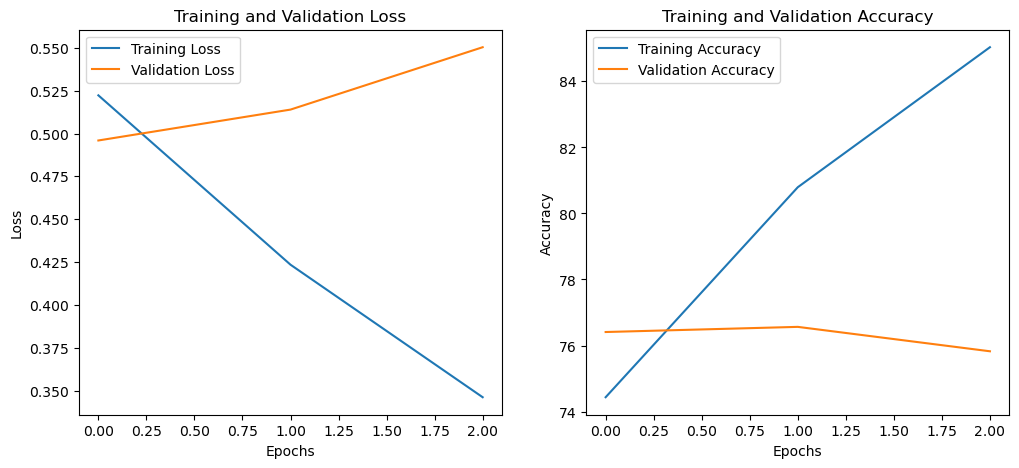

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import time

df_0 = pd.read_csv('twitter_dataset/training.csv', encoding='latin1', header=None, usecols=[0, 5])
print(df_0.head())
df = df_0.sample(frac=0.03)
print(df)
print(df[0].unique())

# Remove rows with missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert the target column to numeric values (0, 1, 2)
df[0] = df[0].apply(lambda x: 0 if x == 0 else 1 if x == 2 else 2)

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove usernames
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a string
    text = ' '.join(tokens)
    return text

# Apply the cleaning function to the text column
df[5] = df[5].apply(clean_text)

train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

class TwitterDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]  # text column is at index 5
        label = self.df.iloc[idx, 0]  # target column is at index 0

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

batch_size = 64
max_len = 128

train_dataset = TwitterDataset(train_df, tokenizer, max_len)
val_dataset = TwitterDataset(val_df, tokenizer, max_len)
test_dataset = TwitterDataset(test_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002)

# Early stopping
early_stopping_patience = 2
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Record the start time
start_time = time.time()

for epoch in range(5):
    model.train()
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = criterion(logits, labels)

        predicted_labels = torch.argmax(logits, dim=1)
        accuracy = (predicted_labels == labels).sum().item() / len(labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += accuracy

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = (total_correct / len(train_loader)) * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1} - Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%')

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = criterion(logits, labels)

            predicted_labels = torch.argmax(logits, dim=1)
            accuracy = (predicted_labels == labels).sum().item() / len(labels)

            total_val_loss += loss.item()
            total_val_correct += accuracy

    avg_eval_loss = total_val_loss / len(val_loader)
    eval_accuracy = (total_val_correct / len(val_loader)) * 100
    val_losses.append(avg_eval_loss)
    val_accuracies.append(eval_accuracy)

    print(f'Valid Loss: {avg_eval_loss}, Valid Accuracy: {eval_accuracy}%')

    # Early stopping
    if avg_eval_loss < best_val_loss:
        best_val_loss = avg_eval_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Record the end time
end_time = time.time()

total_time = end_time - start_time
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Total training time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

Test Loss: 0.5041801174481709
Test Accuracy: 0.7816475495307612
Confusion Matrix:
[[1807  578]
 [ 469 1941]]


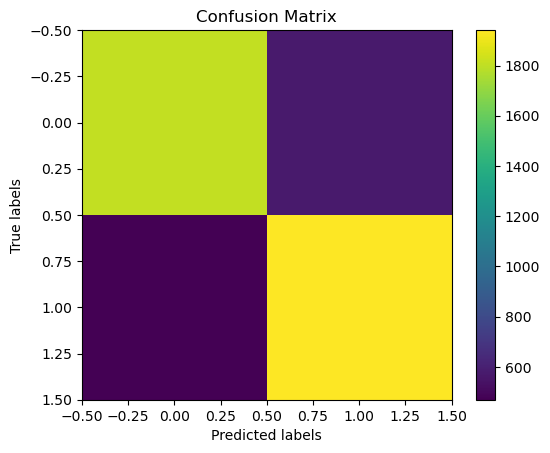

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Evaluation
test_loss = 0
total_correct_test = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = criterion(logits, labels)
        test_loss += loss.item()

        _, predicted = torch.max(logits, dim=1)
        total_correct_test += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = total_correct_test / len(test_loader.dataset)
print(f'Test Loss: {test_loss / len(test_loader)}')
print(f'Test Accuracy: {test_accuracy}')

# Plot confusion matrix
confusion_matrix_test = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(confusion_matrix_test)

plt.imshow(confusion_matrix_test, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [7]:
def classify_tweet(tweet):
    cleaned_tweet = clean_text(tweet)

    encoding = tokenizer.encode_plus(
        cleaned_tweet,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
    
    # Map the predicted label to the corresponding sentiment
    sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment_map[predicted_label]

In [8]:
example_tweet = "I love the new features in the latest update!"
sentiment = classify_tweet(example_tweet)
print(f"The sentiment of the tweet is: {sentiment}")

The sentiment of the tweet is: positive


In [11]:
example_tweet = "I don't like the new features in the latest update!"
sentiment = classify_tweet(example_tweet)
print(f"The sentiment of the tweet is: {sentiment}")

The sentiment of the tweet is: negative
